In [1]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# This method takes in paramaters:
# 1) DATE: Date of recovery for recovered recordings.
# 2) SD_CARD_NUM: The # of the SD card that was recovered with the recordings.
# 3) AUDIO_DUR: The AudioMoth's configuration for the length of each recording.

# This method returns:
# - A DataFrame object that has columns:
#   - File Names, Date, Start Time, End Time, # of LF detections, # of HF detections
#   - File Names are strings and # of LF/HF detections are integers.
#   - Times are in UTC format and Dates are datetime.datetime objects.

def generate_df(recover_folder, AUDIO_DUR=pd.DateOffset(minutes=29, seconds=55)):

    # detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
    detection_dir = f"detections/{recover_folder}"

    # Construct path object linked to the directory of files for datetime-parsing
    file_dir = Path(detection_dir)
    # Extract only the hf-detection files because the datetime information is repeated.
    sorted_files = sorted(file_dir.glob('hf_*.txt'))

    # Create empty DataFrame object with all the required columns    
    df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Iterate through all file paths to extract and store table information for each file
    for i, file in enumerate(sorted_files):
        # Extract name of each file as it is
        file_name = file.name
        # Extracting the datetime object from the name of each file
        file_info = datetime.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")

        # Extract recording name, date, start time, and end time for each file
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        date = file_info.date()
        s_time = file_info.time()
        e_time = (file_info + AUDIO_DUR).time()

        # Calling read_detection to return the table of selections as a dataframe
        # The detections appear twice: in waveform view and spectrogram view, 
        # so we half the total number of detections
        lf_file_detections = read_detection(detection_dir, recording_name, "lf")
        num_lf_detections = lf_file_detections.shape[0]/2
        hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
        num_hf_detections = hf_file_detections.shape[0]/2
        
        # Add new row with the extracted information
        df.loc[len(df.index)] = [recording_name, date, s_time, e_time, num_lf_detections, num_hf_detections]
    
    return df

In [3]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [4]:
def plot_separate(recover_folder, save=True):
    
    # Generate DataFrame to be plotted as a bar graph of LF/HF detections vs. time
    df = generate_df(recover_folder)
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()

    for date in unique_dates:
        day_df = df.loc[df['Date'] == date]
        fig = day_df.plot.bar(x="Start Time (UTC)", title=date, figsize=(16, 6), rot=45).get_figure()
        
        if save:
            save_dir = Path(recover_folder)
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = Path(f"{recover_folder}/{date}.png")
            fig.savefig(save_path, facecolor='w')

In [5]:
def plot_total(recover_folder):
    
    # Generate DataFrame to be plotted as a bar graph of LF/HF detections vs. time
    df = generate_df(recover_folder)
    
    df.plot.bar(x="Start Time (UTC)", title="Total Deployment Session", figsize=(16, 6), fontsize=7, rot=45)

In [6]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220728"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "008"

In [7]:
generate_df(f"recover-{DATE}-{SD_CARD_NUM}-detect")

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220726_003000.WAV,2022-07-26,00:30:00,00:59:55,42.0,0.0
1,20220726_010000.WAV,2022-07-26,01:00:00,01:29:55,18.0,0.0
2,20220726_013000.WAV,2022-07-26,01:30:00,01:59:55,9.0,0.0
3,20220726_020000.WAV,2022-07-26,02:00:00,02:29:55,14.0,0.0
4,20220726_023000.WAV,2022-07-26,02:30:00,02:59:55,3.0,0.0
...,...,...,...,...,...,...
90,20220727_213000.WAV,2022-07-27,21:30:00,21:59:55,4.0,0.0
91,20220727_220000.WAV,2022-07-27,22:00:00,22:29:55,8.0,0.0
92,20220727_223000.WAV,2022-07-27,22:30:00,22:59:55,6.0,0.0
93,20220727_230000.WAV,2022-07-27,23:00:00,23:29:55,12.0,0.0


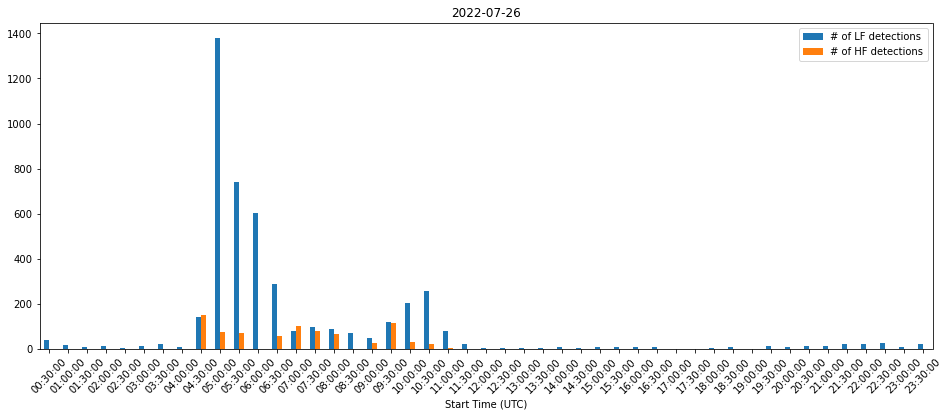

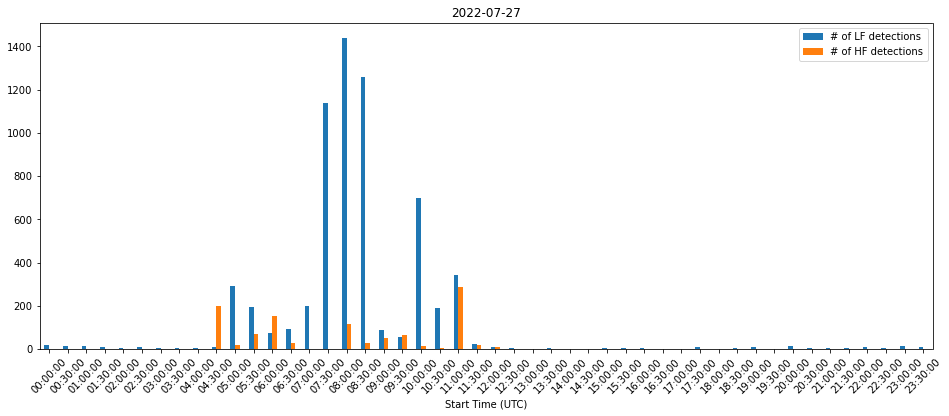

In [8]:
plot_separate(f"recover-{DATE}-{SD_CARD_NUM}-detect")

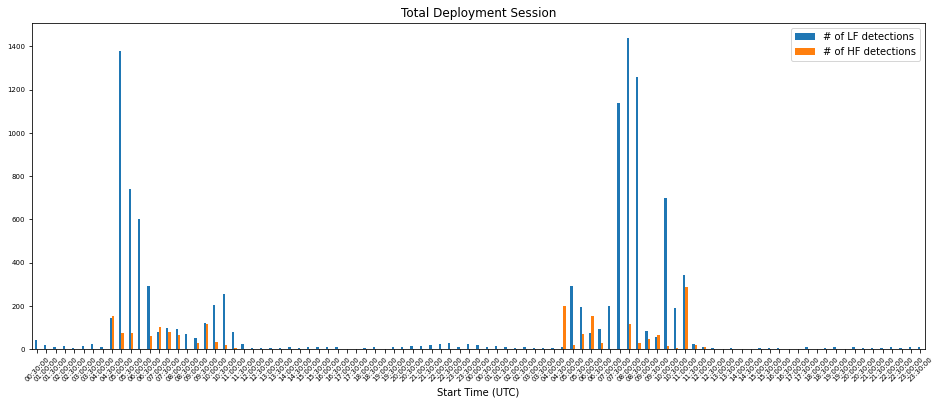

In [9]:
plot_total(f"recover-{DATE}-{SD_CARD_NUM}-detect")